## Boruta Feature Selection Explained in Python
- https://medium.com/geekculture/boruta-feature-selection-explained-in-python-7ae8bf4aa1e7

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.18</div>
<div style="text-align: right"> Last update: 2023.7.18</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

## 구현

In [2]:
from tqdm.notebook import tqdm
import scipy as sp
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

In [3]:
data = pd.read_csv("../data/healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
data.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [5]:
pd.factorize(data["gender"])

(array([0, 1, 0, ..., 1, 0, 1]),
 Index(['Male', 'Female', 'Other'], dtype='object'))

In [6]:
data["gender"] = pd.factorize(data["gender"])[0]
data["ever_married"] = pd.factorize(data["ever_married"])[0]
data["work_type"] = pd.factorize(data["work_type"])[0]
data["Residence_type"] = pd.factorize(data["Residence_type"])[0]
data["smoking_status"] = pd.factorize(data["smoking_status"])[0]

In [7]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,51676,1,61.0,0,0,0,1,1,202.21,NaN,1,1
2,31112,0,80.0,0,1,0,0,1,105.92,32.5,1,1
3,60182,1,49.0,0,0,0,0,0,171.23,34.4,2,1
4,1665,1,79.0,1,0,0,1,1,174.12,24.0,1,1


In [8]:
data.dtypes

id                     int64
gender                 int64
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type              int64
Residence_type         int64
avg_glucose_level    float64
bmi                  float64
smoking_status         int64
stroke                 int64
dtype: object

In [9]:
# additional cleaning
data.dropna(inplace =True)
data.drop("id", axis =1, inplace = True)
data.reset_index(inplace=True, drop=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1
1,0,80.0,0,1,0,0,1,105.92,32.5,1,1
2,1,49.0,0,0,0,0,0,171.23,34.4,2,1
3,1,79.0,1,0,0,1,1,174.12,24.0,1,1
4,0,81.0,0,0,0,0,0,186.21,29.0,0,1


데이터셋 만들기

In [10]:
X = data.drop("stroke", axis = 1)
y = data["stroke"]

이제 매뉴얼로 작업을 진행해보자.

1. 쉐도우 피처 생성

In [11]:
for col in X.columns:
    X[f"shadow_{col}"] = X[col].sample(frac = 1).reset_index(drop = True)

In [12]:
X.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,shadow_gender,shadow_age,shadow_hypertension,shadow_heart_disease,shadow_ever_married,shadow_work_type,shadow_Residence_type,shadow_avg_glucose_level,shadow_bmi,shadow_smoking_status
0,0,67.0,0,1,0,0,0,228.69,36.6,0,1,61.0,0,0,1,0,0,102.40,23.7,2
1,0,80.0,0,1,0,0,1,105.92,32.5,1,0,67.0,0,0,1,2,0,154.75,43.7,3
2,1,49.0,0,0,0,0,0,171.23,34.4,2,1,44.0,0,0,0,0,0,76.66,21.8,3
3,1,79.0,1,0,0,1,1,174.12,24.0,1,0,21.0,1,0,0,0,1,91.65,30.3,1
4,0,81.0,0,0,0,0,0,186.21,29.0,0,1,27.0,1,1,0,2,1,81.68,23.9,1


2. importance 계산

In [13]:
def get_important_features(X, y):
    rf = RandomForestClassifier(max_depth=20)
    rf.fit(X, y)
    
    importances = {feature_name : f_importance for feature_name, f_importance \
        in zip(X.columns, rf.feature_importances_)}
    
    #isolate importances of shadow features
    only_shadow_feat_importance = {key: value for key, value in importances.items() if \
        "shadow" in key}
    
    # get importance level of most important shadow feature
    highest_shadow_feature = \
        list(dict(sorted(only_shadow_feat_importance.items(), 
                         key = lambda item: item[1], reverse=True)).values())[0]
        
    # get original feature which fulfill boruta selection criteria
    selected_features = [key for key, value in importances.items() \
        if value > highest_shadow_feature]
    
    return selected_features

이 함수는 심장마비 데이터 세트에 대해 랜덤 포레스트 분류기를 훈련합니다.  
분류기는 'feature_importances_' 변수에 있는 각 특징에 할당하는 중요도를 반환합니다.  

그런 다음 중요도와 함께 각 피처 딕셔너리를 생성하고 가장 중요한 쉐도우 피처를 골라냅니다.  

마지막으로, 중요도 점수가 단일화된 쉐도우 피처보다 큰 모든 원본 피처가 포함된 딕셔너리를 반환합니다.   

이제 한 번의 시도만으로는 충분하지 않으므로 만족스러운 결과를 얻으려면 여러 번의 시도를 실행해야 합니다.

Multiple trials

In [14]:
TRIALS = 50

feature_hits = {i:0 for i in data.columns}
for _ in tqdm(range(TRIALS)):
    imp_features = get_important_features(X, y)
    for key, _ in feature_hits.items():
        if key in imp_features: feature_hits[key] += 1
        
print(feature_hits)

  0%|          | 0/50 [00:00<?, ?it/s]

{'gender': 0, 'age': 50, 'hypertension': 0, 'heart_disease': 0, 'ever_married': 0, 'work_type': 0, 'Residence_type': 0, 'avg_glucose_level': 50, 'bmi': 1, 'smoking_status': 0, 'stroke': 0}


- age, avg_glucose_level은 50번 중요한 요소에 포함되었다.  
- BMI는 한번 포함되었다.

BMI가 중요한지 확인하기 위해서 Binomial distribution을 사용하자.

Binomial Distribution

아래 코드는 이항분포에 따른 확률을 리턴한다.

In [15]:
pmf = [sp.stats.binom.pmf(x, TRIALS, 0.5) for x in range(TRIALS + 1)]
pmf

[8.881784197001252e-16,
 4.440892098500611e-14,
 1.088018564132656e-12,
 1.7408297026122513e-11,
 2.0454749005693856e-10,
 1.8818369085238336e-09,
 1.4113776813928754e-08,
 8.871516854469498e-08,
 4.768440309277371e-07,
 2.225272144329444e-06,
 9.123615791750725e-06,
 3.3176784697275164e-05,
 0.00010782455026614456,
 0.00031517945462411576,
 0.000832974272935162,
 0.0019991382550443894,
 0.004373114932909585,
 0.008746229865819178,
 0.01603475475400185,
 0.027005902743582038,
 0.04185914925255224,
 0.05979878464650314,
 0.07882567067039052,
 0.09596168603351876,
 0.1079568967877087,
 0.11227517265921709,
 0.1079568967877087,
 0.09596168603351876,
 0.0788256706703905,
 0.05979878464650314,
 0.041859149252552165,
 0.027005902743582066,
 0.016034754754001845,
 0.00874622986581918,
 0.004373114932909586,
 0.00199913825504439,
 0.0008329742729351618,
 0.0003151794546241157,
 0.00010782455026614456,
 3.317678469727516e-05,
 9.123615791750725e-06,
 2.225272144329444e-06,
 4.768440309277372e-0

확률 0.5의 이항분포는 꼬리 부분에 전체 확률의 5%가 있는 종모양의 곡선을 가진다.

먼저 꼬리를 형성하는 반복 횟수를 알려주는 함수가 필요하다.???

In [16]:
# trails_in_green_zone
def get_tail_items(pmf):
    total = 0
    for i, x in enumerate(pmf):
        total += x
        if total >= 0.05:
            break
    return i

규칙은 간단합니다.    
반복 횟수가 오른쪽 꼬리에 속하면 녹색 영역(반드시 유지해야 하는 기능)이라고 합니다.   
종 모양 사이에 있으면 파란색 영역(가지고 놀아도 되는 피처), 오른쪽 꼬리에 있으면 빨간색 영역(삭제해야 하는 피처)이라고 합니다.

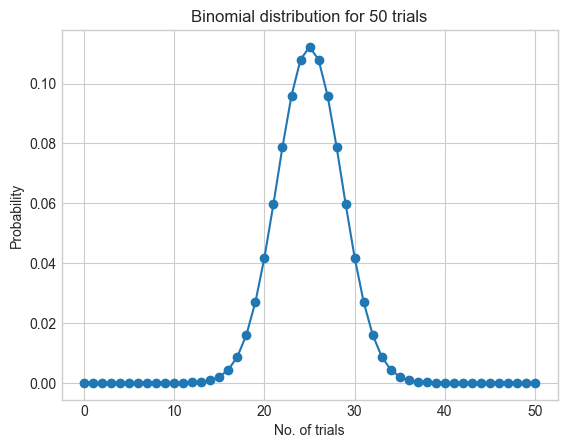

In [17]:
# plot the binomial distribution
plt.plot([i for i in range(TRIALS + 1)], pmf,"-o")
plt.title(f"Binomial distribution for {TRIALS} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.grid(True)

### Final Selection

이제 위에서 설명한 그린, 블루, 레드 영역에 속하는 기능을 결정하는 규칙을 코딩하기만 하면 됩니다.

In [18]:
def choose_features(feature_hits, TRIALS, thresh):
    green_zone_thresh = TRIALS - thresh
    blue_zone_upper = green_zone_thresh
    blue_zone_lower = thresh
    
    green_zone = [key for key, value in feature_hits.items() if value >= green_zone_thresh]
    blue_zone = [key for key, value in feature_hits.items() if \
        (value >= blue_zone_lower and value < blue_zone_upper)]
    return green_zone, blue_zone

In [19]:
thresh = get_tail_items(pmf)
green, blue = choose_features(feature_hits, TRIALS, thresh)
green,blue

(['age', 'avg_glucose_level'], [])